<h1>Exploratory Data Analysis</h1>

In [106]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker

import seaborn as sns

from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wordnet
from nltk.probability import FreqDist

import re
import contractions
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.pipeline import make_pipeline



In [3]:
#Load and parse data

train_df = pd.read_csv('//Users//datdao//Downloads//archive//train.txt', sep=";", header=None, names=['text','emotion'])
test_df = pd.read_csv('//Users//datdao//Downloads//archive//test.txt', sep=";", header=None, names=['text','emotion'])
val_df = pd.read_csv('//Users//datdao//Downloads//archive//val.txt', sep=";", header=None, names=['text','emotion'])

In [80]:
#view data 
train_df.head()

,text,emotion,text_prep,token,emo_label
0,i didnt feel humiliated,sadness,not humiliate,"[not, humiliate]",0
1,i can go from feeling so hopeless to so damned...,sadness,go hopeless damn hopeful around someone care a...,"[go, hopeless, damn, hopeful, around, someone,...",0
2,im grabbing a minute to post i feel greedy wrong,anger,grab minute post greedy wrong,"[grab, minute, post, greedy, wrong]",0
3,i am ever feeling nostalgic about the fireplac...,love,ever nostalgic fireplace know still property,"[ever, nostalgic, fireplace, know, still, prop...",1
4,i am feeling grouchy,anger,grouchy,[grouchy],0


In [4]:
#Checking null values

train_df.info()
print()
test_df.info()
print()
val_df.info()
print()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     16000 non-null  object
 1   emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     2000 non-null   object
 1   emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB



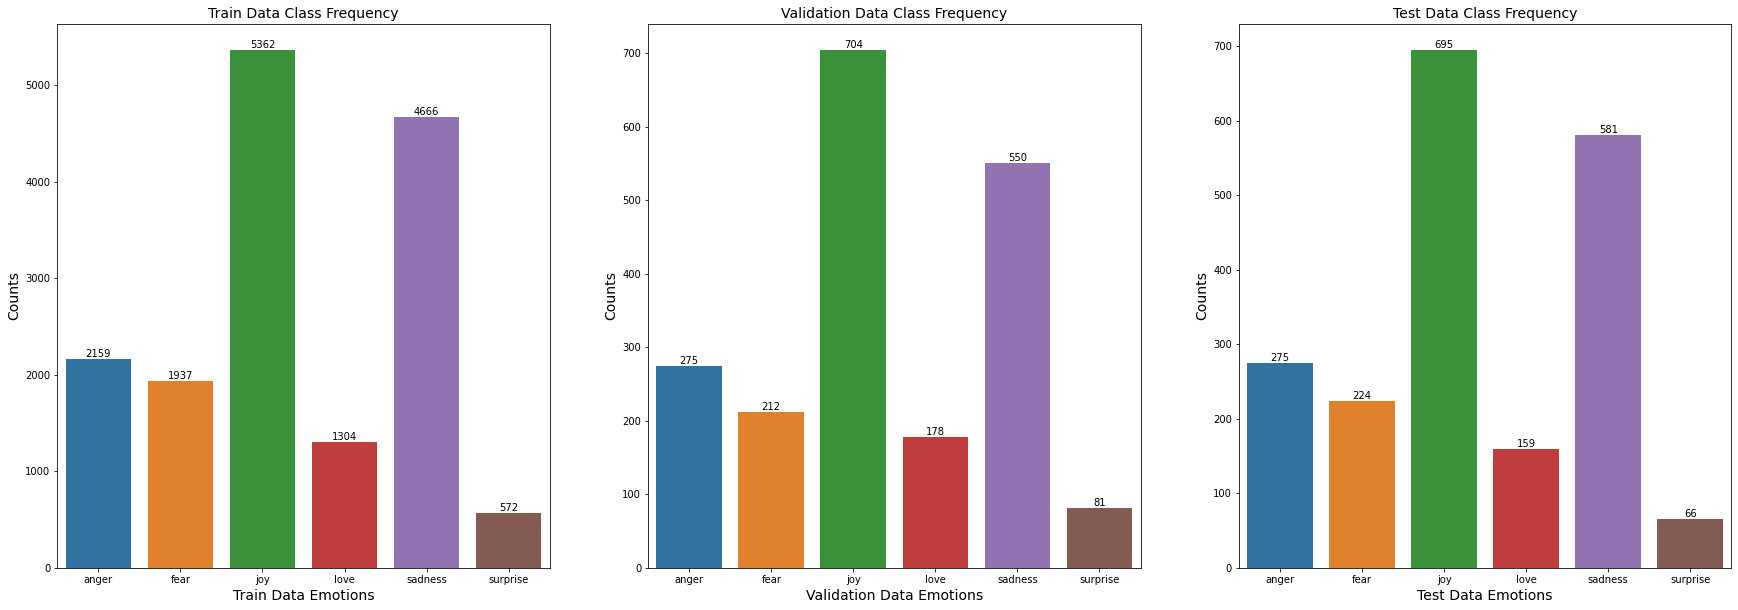

In [12]:
#Checking for data distribution (data balance)

data = {'Train Data': train_df, 'Validation Data': val_df, 'Test Data': test_df}
bar, ax = plt.subplots(1,3, figsize=(30, 10))
emo_order = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

for index, datum in enumerate(data):
    sns.countplot(ax = ax[index],x = 'emotion', data = data[datum], order=emo_order)
    ax[index].set_title(datum +' Class Frequency', size=14)
    ax[index].set_ylabel('Counts', size=14)
    ax[index].set_xlabel(datum +' Emotions', size=14)
    ax[index].bar_label(ax[index].containers[0])
plt.show()




In [24]:
# Preprocessing: lower cases, remove non-text elements & stopwords, remove contractions, and tokenize data

lm = WordNetLemmatizer()

stoplist = ['feel', 'felt', 'feeling', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your',
            'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
            'she', 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',
            'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is',
            'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
            'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
            'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below',
            'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
            'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
            'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 'can', 'will',
            'just', 'should', 'now', 'href',  'http', 'www', 'img', 'src',]

def wordnet_pos_code(tag):
    '''Translation from nltk tags to Wordnet code'''
    if tag.startswith('NN'):
        return wordnet.NOUN
    elif tag.startswith('VB'):
        return wordnet.VERB
    elif tag.startswith('JJ'):
        return wordnet.ADJ
    elif tag.startswith('RB'):
        return wordnet.ADV
    else:
        return None

def data_prep(df):
    corpus = []
    for i in df:
        item = re.sub("[^a-zA-Z]"," ",str(i))
        item = contractions.fix(item)
        item = item.lower() 
        item = item.split()
        pos_tagging = pos_tag([i for i in item if i not in set(stoplist)])
        for word in pos_tagging:
            pos = wordnet_pos_code(word[1])
            if pos is not None:
                item = [lm.lemmatize(word, pos=pos) for word in item if word not in set(stoplist)]
        corpus.append(' '.join(str(x) for x in item))
    return corpus
        
def txt_tokenizer(df):
    tokens = word_tokenize(df)
    return tokens


In [30]:
train_df['text_prep'] = data_prep(train_df['text'])
test_df['text_prep'] = data_prep(test_df['text'])
val_df['text_prep'] = data_prep(val_df['text'])

train_df['token'] = train_df['text_prep'].apply(txt_tokenizer)
test_df['token'] = test_df['text_prep'].apply(txt_tokenizer)
val_df['token'] = val_df['text_prep'].apply(txt_tokenizer)

In [42]:
# Most frequent words
def get_wf(text):
    return text.str.split(expand=True).stack().value_counts()

word_freq = get_wf(train_df.text_prep)

word_freq[:10]

not       3134
like      2997
get       1289
make      1226
go        1127
know      1039
think      983
time       978
really     942
t          897
dtype: int64

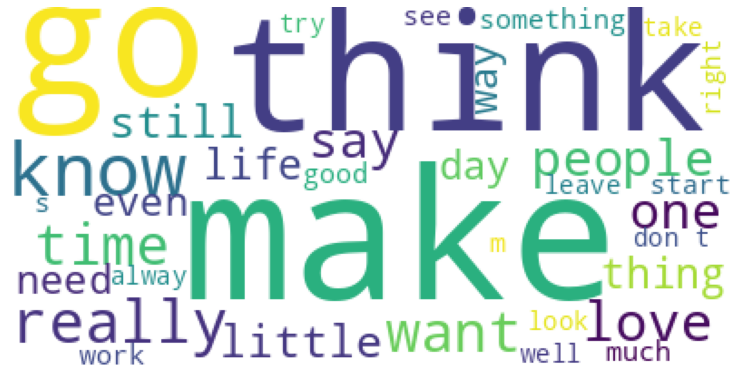

In [90]:
# Visualize most frequent words

all_words = ' '.join([line for line in train_df['text_prep']])
word_cloud = WordCloud(max_words=35, max_font_size=100, margin=0, background_color = "white", random_state=21).generate(all_words)
plt.figure(figsize=(13,13))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()





In [66]:
# Most frequent bigram
def most_freq_ngram(number):
    """Function for 20 n-grams generation that happens most frequently """
    c_vec_number = CountVectorizer(stop_words=stoplist, ngram_range=(number,number+1))
    # matrix of ngrams
    ngrams_number = c_vec_number.fit_transform(train_df.text_prep)
    # count frequency of ngrams
    count_values_number = ngrams_number.toarray().sum(axis=0)
    # list of ngrams
    vocab_number = c_vec_number.vocabulary_
    df_ngram_number = pd.DataFrame(sorted([(count_values_number[i],k) for k,i in vocab_number.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1: 'n-gram'})
    return df_ngram_number[:20]

In [65]:
print(most_freq_ngram(2))

    frequency \number-gram
0         145     not know
1         122     not want
2         101     not like
3          92     like not
4          84    could not
5          76  even though
6          76  cannot help
7          69   not really
8          65    would not
9          59       not go
10         59      not get
11         57     not sure
12         56     not even
13         55       no one
14         54     know not
15         53     don know
16         50  little bite
17         48    not think
18         47    every day
19         47     don want


In [67]:
print(most_freq_ngram(3))

    frequency                n-gram
0          20        could not help
1           9       even though not
2           8       not really want
3           7       really not like
4           7       not really like
5           7       not good enough
6           7         not even know
7           7        no matter much
8           7           like no one
9           7  forgive accept allow
10          6         not want make
11          6           not like go
12          6            not go lie
13          6          like not get
14          6      like damage good
15          6        like could not
16          6        cool cool cool
17          6    cannot help little
18          5       not think could
19          5         not know want


In [68]:
print(most_freq_ngram(4))

    frequency                                 n-gram
0           4              rel nofollow target blank
1           4                  could not help little
2           4                    cool cool cool cool
3           3      work sometimes think people might
4           3            work sometimes think people
5           3  unwelcome work sometimes think people
6           3         unwelcome work sometimes think
7           3                think people might talk
8           3                    take back thing say
9           3      sometimes think people might talk
10          3           sometimes think people might
11          3             something tragic go happen
12          3                       six day not know
13          3             like almost every day week
14          3                  like almost every day
15          3                   first time long time
16          3                  class post count link
17          3                  almost every da

In [70]:
most_freq_ngram(5)

,frequency,n-gram
0,3,work sometimes think people might talk
1,3,work sometimes think people might
2,3,unwelcome work sometimes think people might
3,3,unwelcome work sometimes think people
4,3,sometimes think people might talk
5,3,like almost every day week
6,2,youtube next best thing entertainment
7,2,youtube id quite like explain think
8,2,youtube id quite like explain
9,2,yesterday post peak day illness still


In [71]:
def manual_encoder(text):
    negative = ['sadness', 'anger', 'fear']
    return 0 if text in negative else 1 

In [72]:
train_df['emo_label'] = train_df['emotion'].apply(manual_encoder)
test_df['emo_label'] = test_df['emotion'].apply(manual_encoder)
val_df['emo_label'] = val_df['emotion'].apply(manual_encoder)

0    8762
1    7238
Name: emo_label, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


/Applications/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


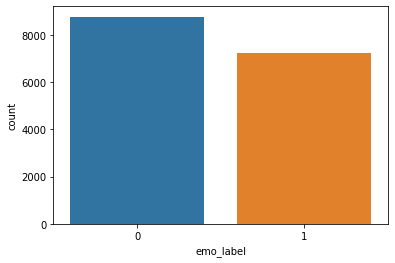

In [74]:
# Check for data balance between the two classes
print(train_df.emo_label.value_counts())
print(sns.countplot(train_df.emo_label))

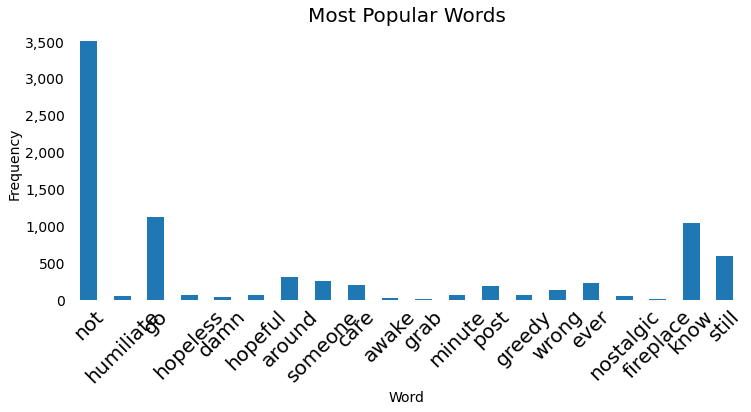

In [81]:
# Most popular words after text preprocessing 

word_list =[]
for i, row in train_df.iterrows():
    for word in row['token']:
            word_list.append(word)
fdist = FreqDist(word_list)

df_fdist = pd.DataFrame.from_dict(fdist, orient='index')
df_fdist.columns = ['Frequency']
df_fdist.index
chart = df_fdist.head(20).plot(kind='bar', fontsize=14, figsize=(12, 5))
plt.title("Most Popular Words", fontsize=20)
chart.set_xlabel("Word", fontsize=14)
chart.set_ylabel("Frequency", fontsize=14)
chart.tick_params(bottom=False, left=False, top=False, right=False)
for key, spine in chart.spines.items():
    spine.set_visible(False)
plt.grid(False)
plt.xticks(fontsize=20)
chart.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
chart.tick_params(axis='x', rotation=45 )
chart.get_legend().remove()
plt.show(chart)



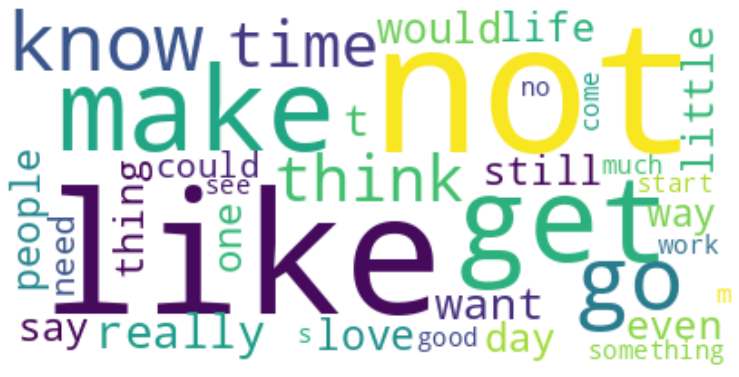

In [82]:
#Create word cloud after text preprocessing
wordcloud = WordCloud(max_words=35, max_font_size=100, margin=0, background_color = "white")
wordcloud.generate_from_frequencies(frequencies=df_fdist['Frequency'].to_dict())
plt.figure(figsize=(13,13),)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Positive words


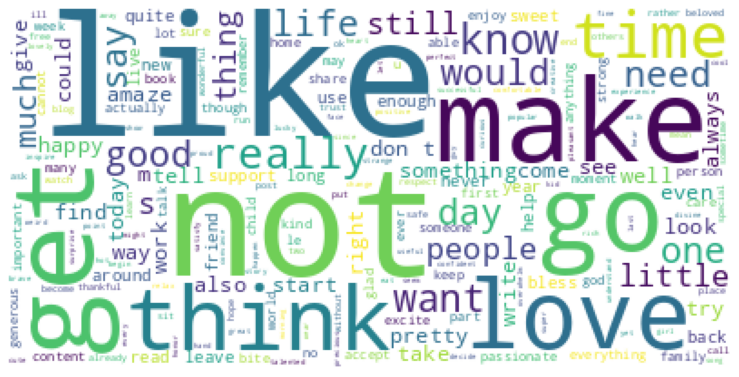

Negative words


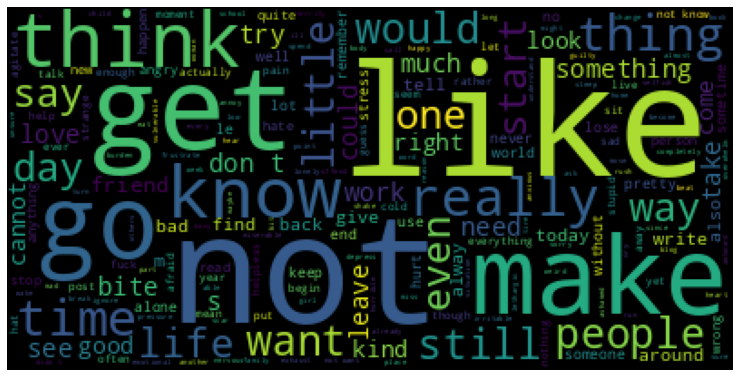

In [97]:
train_pos = train_df[train_df['emo_label'] == 1]
train_pos = train_pos['text_prep']
train_neg = train_df[train_df['emo_label'] == 0]
train_neg = train_neg['text_prep']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()])
    wordcloud = WordCloud(stopwords=stoplist,
                      background_color=color
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [98]:
# Most common words stratified by its POS and sign - part 1   

pos_normal_words = ' '.join(str(x) for x in train_pos)
pos_normal_words = contractions.fix(pos_normal_words)
pos_normal_words = pos_normal_words.lower() 
pos_normal_words = pos_normal_words.split()
pos_tagged_words = pos_tag([word for word in pos_normal_words if word not in stoplist])

pos_words = []

for word in pos_tagged_words:
    pos = wordnet_pos_code(word[1])

    if pos is not None:
        pos_words.append((lm.lemmatize(word[0], pos=pos), word[1]))

pos_fdist = FreqDist(pos_words)



neg_normal_words = ' '.join(str(x) for x in train_neg)
neg_normal_words = contractions.fix(neg_normal_words)
neg_normal_words = neg_normal_words.lower() 
neg_normal_words = neg_normal_words.split()

neg_tagged_words = pos_tag([word for word in neg_normal_words if word not in stoplist])

neg_words = []

for word in neg_tagged_words:
    pos = wordnet_pos_code(word[1])
    if pos is not None:
        neg_words.append((lm.lemmatize(word[0], pos=pos), word[1]))

neg_fdist = FreqDist(neg_words)




In [99]:
# Most common words stratified by its POS and sign - part 2   

pos_nouns = []
pos_verbs = []
pos_adjectives = []
pos_adverbs = []

for word, pos in pos_words:
    if pos.startswith('NN') : 
        pos_nouns.append(word)
    elif pos.startswith('VB'):
        pos_verbs.append(word)
    elif pos.startswith('JJ'):
        pos_adjectives.append(word)
    elif pos.startswith('RB'):
        pos_adverbs.append(word)

pos_nouns_fdist = FreqDist(pos_nouns)
pos_verbs_fdist = FreqDist(pos_verbs)
pos_adjectives_fdist = FreqDist(pos_adjectives)
pos_adverbs_fdist = FreqDist(pos_adverbs)


In [100]:
# Most common words stratified by its POS and sign - part 3

print("Positive Nouns:\n", pos_nouns_fdist.most_common(50))
print("Positive Verbs:\n", pos_verbs_fdist.most_common(50))
print("Positive Adjectives:\n", pos_adjectives_fdist.most_common(50))
print("Positive Adverbs:\n", pos_adverbs_fdist.most_common(50))

Positive Nouns:
 [('time', 458), ('day', 307), ('people', 291), ('life', 280), ('t', 259), ('thing', 257), ('something', 250), ('way', 228), ('work', 211), ('year', 175), ('love', 171), ('get', 149), ('today', 147), ('m', 122), ('look', 113), ('family', 113), ('support', 111), ('don', 109), ('s', 108), ('help', 107), ('lot', 104), ('someone', 104), ('everything', 103), ('friend', 102), ('cannot', 101), ('try', 99), ('anything', 97), ('kind', 95), ('share', 94), ('week', 94), ('person', 94), ('home', 91), ('part', 91), ('care', 90), ('world', 88), ('moment', 87), ('book', 84), ('use', 82), ('place', 81), ('start', 80), ('others', 80), ('bless', 79), ('god', 71), ('post', 71), ('morning', 70), ('hand', 69), ('blog', 67), ('value', 67), ('talk', 66), ('need', 65)]
Positive Verbs:
 [('make', 564), ('go', 499), ('get', 417), ('think', 367), ('know', 354), ('want', 323), ('say', 273), ('love', 248), ('see', 172), ('take', 166), ('come', 163), ('find', 146), ('need', 141), ('leave', 120), ('l

In [101]:
# Most common words stratified by its POS and sign - part 4

neg_nouns = []
neg_verbs = []
neg_adjectives = []
neg_adverbs = []

for word, pos in neg_words:
    if pos.startswith('NN') : 
        neg_nouns.append(word)
    elif pos.startswith('VB'):
        neg_verbs.append(word)
    elif pos.startswith('JJ'):
        neg_adjectives.append(word)
    elif pos.startswith('RB'):
        neg_adverbs.append(word)

neg_nouns_fdist = FreqDist(neg_nouns)
neg_verbs_fdist = FreqDist(neg_verbs)
neg_adjectives_fdist = FreqDist(neg_adjectives)
neg_adverbs_fdist = FreqDist(neg_adverbs)

In [103]:
# Most common words stratified by its POS and sign - part 5

print("Negative Nouns:\n", neg_nouns_fdist.most_common(50))
print("Negative Verbs:\n", neg_verbs_fdist.most_common(50))
print("Negative Adjectives:\n", neg_adjectives_fdist.most_common(50))
print("Negative Adverbs:\n", neg_adverbs_fdist.most_common(50))

Negative Nouns:
 [('time', 520), ('thing', 415), ('t', 374), ('people', 373), ('day', 368), ('life', 305), ('way', 300), ('something', 264), ('work', 217), ('kind', 189), ('today', 185), ('cannot', 183), ('get', 173), ('year', 162), ('don', 158), ('someone', 155), ('week', 142), ('lot', 142), ('friend', 141), ('m', 137), ('start', 134), ('try', 128), ('help', 126), ('anything', 122), ('person', 121), ('home', 119), ('world', 117), ('look', 109), ('talk', 105), ('everything', 104), ('bite', 102), ('heart', 101), ('s', 100), ('use', 96), ('moment', 95), ('stress', 94), ('nothing', 94), ('end', 92), ('post', 86), ('pain', 85), ('reason', 85), ('anyone', 84), ('night', 83), ('think', 81), ('family', 80), ('school', 80), ('everyone', 79), ('word', 78), ('love', 78), ('place', 75)]
Negative Verbs:
 [('go', 602), ('make', 547), ('get', 544), ('know', 535), ('think', 474), ('want', 426), ('say', 340), ('leave', 210), ('take', 200), ('come', 192), ('see', 184), ('find', 148), ('need', 139), ('l

In [111]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stoplist, ngram_range=(3,4))
lda = LatentDirichletAllocation(n_components=3)
pipe = make_pipeline(tfidf_vectorizer, lda)
pipe.fit(train_df['text_prep'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda, tfidf_vectorizer.get_feature_names(), n_top_words=3)

Topic #0: little sarcastic today, still crave sweet food, still crave sweet
Topic #1: could not help, still completely accept, choose make amaze
Topic #2: still bite shake, selfish self indulgent, like not care



In [109]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stoplist, ngram_range=(2,3))
nmf = NMF(n_components=3)
pipe = make_pipeline(tfidf_vectorizer, nmf)
pipe.fit(train_df['text_prep'])
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += ", ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(nmf, tfidf_vectorizer.get_feature_names(), n_top_words=3)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic #0: not know, stupid not, stupid not know
Topic #1: cannot help, help little, cannot help little
Topic #2: like not, not want, not like

